In [306]:
%matplotlib widget

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.cluster import KMeans

from PointCloudDataFrame import PointCloudDataFrame

In [307]:
pcd_raw = o3d.io.read_point_cloud('input/blake-new.ply')

In [308]:
pcd = pcd_raw.voxel_down_sample(voxel_size=0.001)  # 1mm
df = PointCloudDataFrame.from_pcd(pcd)
# o3d.visualization.draw_geometries([pcd])

In [309]:
df_threshold = df[(df['s'] < 0.125) & (df['v'] > 0.2)]
pcd_threshold = df_threshold.to_pcd()
# o3d.visualization.draw_geometries([pcd_threshold])

In [310]:
_, ind = pcd_threshold.remove_radius_outlier(nb_points=70, radius=0.005)
pcd_inliers = pcd_threshold.select_by_index(ind)
df_inliers = PointCloudDataFrame.from_pcd(pcd_inliers)
# o3d.visualization.draw_geometries([pcd_inliers])

num_means = list(range(80, 150))
models: list[KMeans] = []
points = np.asarray(pcd_inliers.points)

for i in num_means:
    model = KMeans(n_clusters=i, n_init='auto', random_state=1)
    model.fit(points)
    models.append(model)

errors: list[float] = []
min_dists: list[float] = []

for model in models:
    errors.append(-model.score(points))
    dists, _ = cKDTree(model.cluster_centers_).query(model.cluster_centers_, k=[2])
    min_dists.append(dists.min())

fig, ax = plt.subplots()

ax.plot(num_means, errors)

ax.set_xlabel('number of means')
ax.set_ylabel('error')
ax.set_ylim(0)

plt.show()

fig, ax = plt.subplots()

ax.plot(num_means, min_dists)

ax.set_xlabel('number of means')
ax.set_ylabel('minimum distance')
ax.set_ylim(0)

plt.show()

fig, ax = plt.subplots()

ax.plot(num_means, np.divide(min_dists, errors))

ax.set_xlabel('number of means')
ax.set_ylabel('minimum distance divided by error')

plt.show()

best_i = np.divide(min_dists, errors).argmax()
best_num = num_means[best_i]

print(best_num)

In [311]:
model = KMeans(n_clusters=126, n_init='auto', random_state=1)
model.fit(pcd_inliers.points)

KMeans(n_clusters=126, n_init='auto', random_state=1)

In [312]:
clusters = o3d.geometry.PointCloud()
clusters.points = o3d.utility.Vector3dVector(model.cluster_centers_)
pcd_test = o3d.geometry.PointCloud(pcd_inliers.points)
pcd_test.paint_uniform_color([0.8, 0.8, 0.8])
o3d.visualization.draw_geometries([clusters])

labels = models[best_i].labels_ 
num_labels = len(set(labels).difference({-1}))
print(num_labels)

model_kmeans_centers = []
for i in range(num_labels):
    model_kmeans_centers.append(
        np.mean(df_inliers[labels==i][['x', 'y', 'z']], axis=0)
    )

for i in range(num_labels):
    point = model_kmeans_centers[i]
    filter = ((df['x'] - point['x'])**2 + (df['y'] - point['y'])**2 + (df['z'] - point['z'])**2) < 0.006**2

    pcd_temp = df[filter].to_pcd()
    pcd_temp.paint_uniform_color([0, 0.8, 0])

    o3d.visualization.draw_geometries([pcd_temp, pcd])

# Register

In [313]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation
import heapq
import pandas as pd
from itertools import count

from Cube import Cube
from PointCloudDataFrame import PointCloudDataFrame

In [314]:
fix = pd.read_csv('model/model1.csv', index_col='label')

In [315]:
theta = np.random.rand(3)
print(theta)
offset = np.random.rand(3)
print(offset)

mov = model.cluster_centers_
# mov = Rotation.from_rotvec(theta).apply(mov) + offset
mov = pd.DataFrame(mov, columns=['x', 'y', 'z'])

[0.06777289 0.10750552 0.10308391]
[0.20045172 0.40450435 0.68706904]


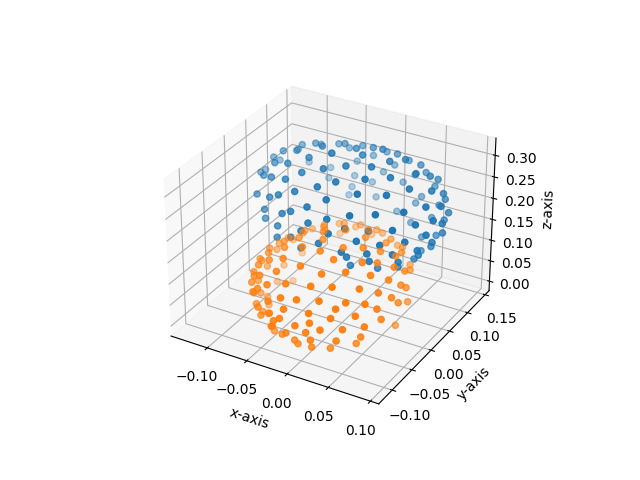

In [316]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fix['x'], fix['y'], fix['z'])
ax.scatter(mov['x'], mov['y'], mov['z'])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

In [317]:
def tivs(array: np.ndarray):
    l = list()
    for i1, row1 in enumerate(array):
        for i2, row2 in enumerate(array):
            if i1 != i2:
                l.append(row1-row2)
    return np.array(l)

In [318]:
def get_largest_sample(array: np.ndarray, ratio: float, sample: int):
    norm = np.linalg.norm(array, axis=1)  # Get magnitudes of vectors
    a = np.concatenate((array, norm.reshape(-1,1)), axis=1)  # Add magnitudes to array
    a = a[a[:,3].argsort(), :3]  # Sort by size and remove magnitudes
    a = a[-int(a.shape[0] * ratio):]  # Select largest vectors
    a = np.random.permutation(a)[:sample]  # Get random sample of largest vectors
    return a

In [319]:
M = get_largest_sample(tivs(mov.to_numpy()), 0.05, 200)
S = get_largest_sample(tivs(fix.to_numpy()), 0.05, 200)

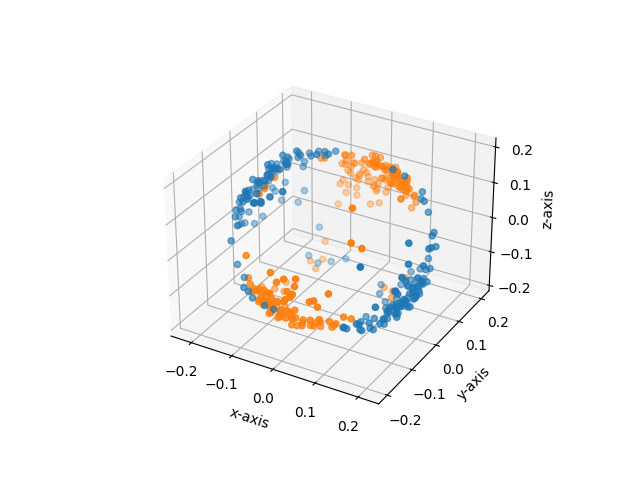

In [320]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(S[:,0], S[:,1], S[:,2])
ax.scatter(M[:,0], M[:,1], M[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

In [321]:
def q_func(moving, fixed, eps):
    return sum(1 - np.clip(np.min(cdist(moving, fixed), axis=1)/eps, 0, 1)**2)

In [322]:
def q_upper_func(moving, fixed, eps, cube: Cube):
    alpha = np.linalg.norm(cube.max - cube.min)/2
    delta = np.sqrt(2 * np.linalg.norm(moving, axis=1)**2 * (1 - np.cos(alpha)))
    return sum(1 - np.clip((np.min(cdist(moving, fixed), axis=1) - delta)/eps, 0, 1)**2)

In [323]:
def rotation_search(M: np.ndarray, S: np.ndarray):
    eps = 0.025
    q_max = 0
    c = Cube([-np.pi, -np.pi, -np.pi], [np.pi, np.pi, np.pi])
    r_opt = Rotation.from_rotvec(c.mid)
    gap = M.shape[0] * 0.25

    counter = count()
    queue = [(-q_upper_func(M, S, eps, c), next(counter), c)]
    
    while len(queue):
        q_upper, _, c = heapq.heappop(queue)
        q_upper *= -1

        if q_upper - q_max < gap:
            break

        r_c = Rotation.from_rotvec(c.mid)
        q_actual = q_func(r_c.apply(M), S, eps)
        if q_actual > q_max:
            q_max = q_actual
            r_opt = r_c
            print(r_opt.as_rotvec(), q_max, q_upper)

        for sub_c in c.subdivide():
            r_c = Rotation.from_rotvec(sub_c.mid)
            q_upper = q_upper_func(r_c.apply(M), S, eps, sub_c)
            if q_upper > q_max:
                heapq.heappush(queue, (-q_upper, next(counter), sub_c))
    
    return r_opt, q_max

In [324]:
r_opt, q_max = rotation_search(M, S)
print(r_opt.as_rotvec(), q_max)

[0. 0. 0.] 16.802554370024072 200.0
[-1.57079633 -1.57079633 -1.57079633] 35.58256516966497 200.0
[-1.57079633  1.57079633  1.57079633] 62.23803141412153 200.0
[ 1.57079633 -1.57079633 -1.57079633] 80.64990473339581 200.0
[ 0.39269908  1.96349541 -1.17809725] 82.51955707276393 200.0
[ 1.50303558 -1.50303558 -0.64415811] 85.46884881012456 199.97824112825123
[-1.0467689   0.88572753 -1.20781026] 88.7186721296752 197.74992611842916
[ 1.32825683 -1.53260403 -0.71521521] 88.72574852099326 195.98230043363435
[ 1.31771004 -1.79687732 -0.83854275] 90.67289690261182 195.9684107813023
[ 1.4257154  -1.79764116 -0.80583914] 90.79630884160254 193.53907369761592
[-0.89209116  1.16658075  2.1272943 ] 91.03786227149563 190.516674437157
[ 2.06167018  2.25801972 -0.29452431] 93.05976636341951 190.26102632821897
[-0.83448555  1.03083509  2.11075756] 94.27670084054724 179.07844008106545
[-0.83448555  1.03083509  2.11075756] 94.27670084054724


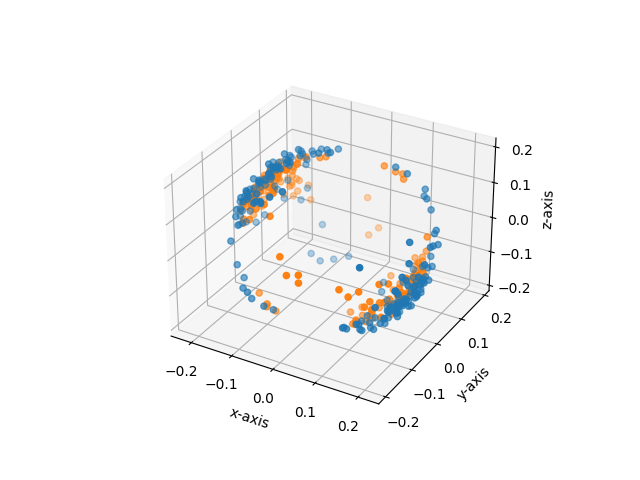

In [325]:
M2 = r_opt.apply(M)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(S[:,0], S[:,1], S[:,2])
ax.scatter(M2[:,0], M2[:,1], M2[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

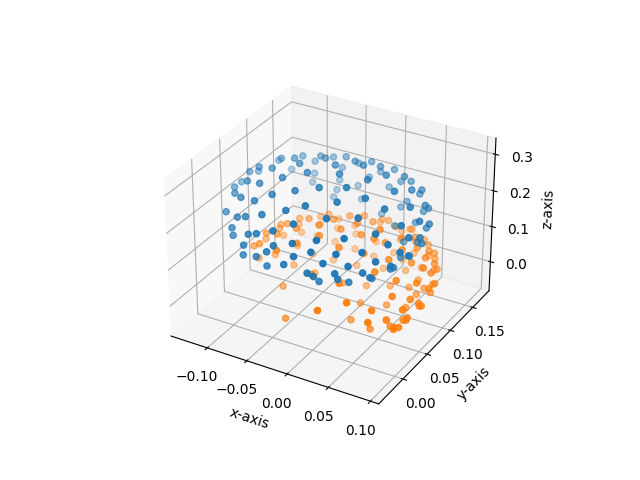

In [326]:
mov2 = r_opt.apply(mov)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fix['x'], fix['y'], fix['z'])
ax.scatter(mov2[:,0], mov2[:,1], mov2[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()

In [327]:
def translation_search(M: np.ndarray, S: np.ndarray):
    eps = 1
    q_max = 0
    c = Cube(np.min(S, axis=0) - np.max(M, axis=0), np.max(S, axis=0) - np.min(M, axis=0))
    t_opt = c.mid
    gap = M.shape[0] * 0.01

    counter = count()
    queue = [(-q_upper_func(M, S, eps, c), next(counter), c)]
    
    while len(queue):
        q_upper, _, c = heapq.heappop(queue)
        q_upper *= -1

        if q_upper - q_max < gap:
            break

        t_c = c.mid
        q_actual = q_func(M + t_c, S, eps)
        if q_actual > q_max:
            q_max = q_actual
            t_opt = t_c
            print(t_c, q_actual)

        for sub_c in c.subdivide():
            t_c = sub_c.mid
            q_upper = q_upper_func(M + t_c, S, eps, sub_c)
            if q_upper > q_max:
                heapq.heappush(queue, (-q_upper, next(counter), sub_c))
    
    return t_opt, q_max

In [328]:
t_opt, q_max = translation_search(r_opt.apply(mov), fix)
print(t_opt, q_max)

[-0.0089138  -0.0192519   0.18152664] 125.94432393958543
[-0.0089138  -0.0192519   0.18152664] 125.94432393958543


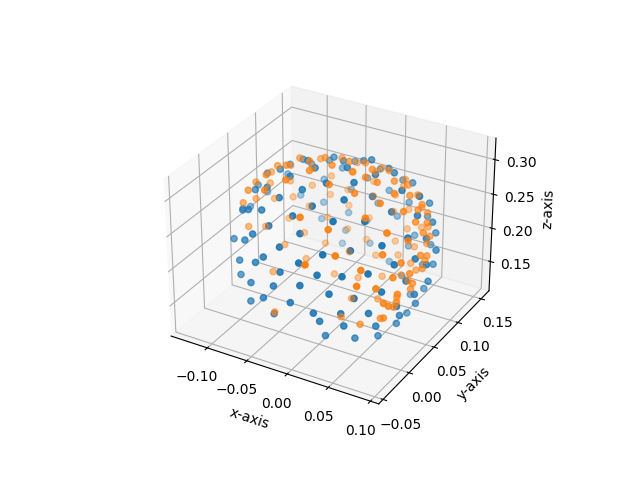

In [329]:
mov3 = r_opt.apply(mov) + t_opt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(fix['x'], fix['y'], fix['z'])
ax.scatter(mov3[:,0], mov3[:,1], mov3[:,2])

ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
plt.show()